# TP2 - Grupo 14

André Lucena Ribas Ferreira - A94956

Paulo André Alegre Pinto - A97391

## Problema 2 - Conway's Game of Life


O Conway’s Game of Life é um exemplo bastante conhecido de um autómato celular . Neste problema vamos modificar as regras do autómato da seguinte forma
 1. O espaço de estados é finito definido por uma grelha de células booleanas (morta=0/viva=1) de dimensão $N\times N$ (com $N>3$), com $(N-1)^2$ células identificadas por índices $\,(i,j)\in \{0..N-2\}$, denominadas de "normais".
 2. No estado inicial todas as células normais estão mortas excepto um quadrado $3\times 3$, designado por “centro”, aleatoriamente posicionado formado apenas por células vivas.
 3. Adicionalmente existem $2N-1$ “células da borda” que correspondem a um dos índices, $i$ ou $j$, ser zero. As células da borda têm valores constantes que, no estado inicial, são gerados aleatoriamente com uma probabilidade $\rho$ de estarem vivas.
 4. As células normais o autómato modificam o estado de acordo com a regra “B3/S23”: i.e. a célula nasce (passa de $0$ a $1$) se tem exatamente 3 vizinhos vivos e sobrevive (mantém-se viva) se o número de vizinhos vivos é 2 ou 3, caso contrário morre ou continua morta.

Como 'inputs', o programa recebe:
 1. $N$, o número de células (total) por cada linha do quadrado ;
 2. $\rho$, a probabildade de cada célula da borda estar viva;
 3. $(c_x,c_y)$, o centro do quadrado $\,3\times 3\,$.

## Análise

Pretende-se modelar o autómato celular do Conway's Game of Life a partir de uma Máquina de Estados Finitos. Para começar, é necessário definir qual o autómato e o que representa cada estado. Cada estado é uma configuração possível do autómato, onde cada célula é uma variável. Para tal, decidiu-se usar uma família de variáveis binárias $x_{i,j}$, onde $(i,j)$ é a sua posição na grelha.

Denotam-se as células $x_{i,j}$, com $i == 0$ ou $j == 0$, como as células da Borda, enquanto que as restantes serão as normais. Nesse sentido, apenas $N-1$ células de cada linha, exceto a primeira, serão normais. Efetivamente, considere-se $N-1$ como $N$ do enunciado.

Definir traço

Também se pretende verificar se duas propriedades são verdadeiras ou não, para cada traço:
 1. Todos os estados contém alguma célula normal viva;
 2. Toda a célula normal está viva em algum estado acessível.

## Implementação

Para a resolução do problema em questão, decidiu-se usar o módulo `pysmt.shortcuts`, com as funcionalidades possíveis para a utilização de um SMT Solver. Importam-se também os tipos deste Solver, a partir do módulo `pysmt.typing`. Para modelar este problema, irá usar-se BitVectors, então escolheu-se o `z3` como Solver.

In [1]:
from pysmt.shortcuts import *
import pysmt.typing as types
name = "z3"

Para além disso, é necessário importar os módulos `numpy` e `random` para a geração de valores aleatórios durante a execução.

In [2]:
import numpy as np
import random as rn

Por fim, alguns módulos auxiliares são necessários para facilitar alguns momentos da implementação. `mathplotlib.pyplot` serve para imprimir para o ecrã os estados do autómato; `functools.reduce` é uma função de ordem superior que opera sobre listas; e `math.comb` para calcular combinações.

In [3]:
import matplotlib.pyplot as plt
from functools import reduce
from math import comb

Como 'input', define-se apenas $N$ e $\rho$, já que o centro é calculado aleatoriamente.

In [4]:
n = 16     # dimensão do espaço de amostras (efetivamente 15)
p = 1

Como primeiro passo, define-se a função `bv_rn`, que gera uma configuração inicial, sem utilização do Solver. Para tal, constrói-se um número inteiro a partir operações lógicas, nomeadamente a disjunção. 

Devido à implementação escolhida, há algumas considerações notáveis:
 1. A ordem da grelha é reversa à habitual. A célula $(0,0)$ encontra-se no canto inferior esquerdo. Como tal, as células da borda consideram-se aquelas em que $i == N-1$ ou $j == N-1$.
 2. O estado onde apenas uma variável binária $x_{i,j} == 1$ equivale ao número inteiro  $2^{i + n*j}$

Para além disso, também devolve qual a borda gerada aleatoriamente, como referência posterior.

In [5]:
# Funções auxiliares para BitVec's, devolve um tuplo (Bitvector, border)
# gera pseudo-aleatoriamente um BitVec para representar o autómato, a partir de um inteiro
def bv_rn():
    I = 0
    J = 0
    c_x = np.random.randint(1, n-2)
    c_y = np.random.randint(1, n-2)
    for i in range(n-1):
        I = I | np.random.binomial(1,p) * 2**(i + n*(n-1))
        I = I | np.random.binomial(1,p) * 2**(n*i+n-1)
    I = I | np.random.binomial(1,p) * 2**(n*n-1)
    J = I
    for i in range(c_x-1, c_x+2):
        for j in range(c_y-1, c_y+2):
            I = I | 2**(i+j*n)
    return (BV(I,n*n), BV(J,n*n))

Como funções auxiliares, definiram-se as seguintes:
 1. `print_state(s)` imprime para o ecrã o estado indicado.

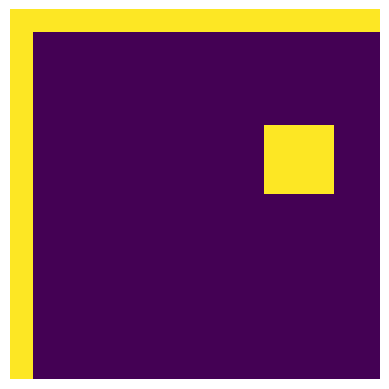

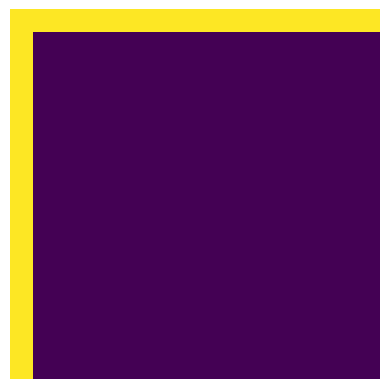

In [6]:
def print_state(s):
    x = list(map(int, list(s.bv_str())))
    x = [x[i:i + n] for i in range(0, len(x), n)]
    plt.imshow(x)
    plt.axis('off')
    plt.show()
    
bv,border = bv_rn()
print_state(bv)
print_state(border)

 2. `bv_selZE(z,i,j)` seleciona a variável na posição $(i,j)$ de $z$ e gera o BitVector de tamanho $n^2$, preenchendo com $0$ os restantes elementos.

In [7]:
def bv_selZE(z,i,j):                    # seleciona o bit (i,j) do BitVec "z" e estende n*n-1
    return BVZExt(BVExtract(z,start=i+j*n,end=i+j*n),n*n-1)

 3. `bv_sel(z,i,j)` seleciona a variável na posição $(i,j)$ de $z$.

In [8]:
def bv_sel(z,i,j):                    # seleciona o bit (i,j) do BitVec "z"
    return BVExtract(z,start=i+j*n,end=i+j*n)

 4. `full_border` gera um BitVector com a borda completamente preenchida.

In [18]:
def full_border():
    I = 0
    for i in range(n-1):
        I = I | 2**(i + n*(n-1))
        I = I | 2**(n*i+n-1)
    I = I | 2**(n*n-1)
    full_border = BV(I,n*n)
    return full_border
full_border = full_border()

Como funções necessárias para a modelação, definem-se `declare(i)`, que cria a i-ésima cópia do estado, e `trans(curr, prox)`, que gera um predicado a partir de dois estados que define as condições de transição entre eles.

Para `declare(i)`, basta gerar uma variável do tipo BitVector.

In [10]:
def declare(i): #declara um bitvector de tamanho n*n
    state = Symbol('s'+str(i),types.BVType(n*n))
    return state

Para `trans(curr,prox)`, são necessárias duas considerações:
 1. A manutenção das células da borda, de acordo com $border$;
 2. A regra "B3/S23", que ditará quais os estados vivos/mortos no estado seguinte.
 
Para cada $x_{i,j}$ variável do estado $curr$, a satisfação de $2$ pode ser traduzida por, com $x'_{i,j}$ variável de $prox$.

$$ x'_{i,j} == 1 \quad \mbox{se e só se} \quad (x_{i,j} == 1 \& s == 4) | s == 3$$

Onde $s$ é a soma, para cada $y$ estado de $curr$ adjacente a $x_{i,j}$:

$$  x_{i,j} + \sum_{y} y  $$

Nos restantes casos, $x´_{i,j} == 0$, o que representa todos os casos possíveis.

In [11]:
def trans(curr, prox): #define uma transição entre dois estados do problema
    r = []
    for i in range(n):
        r.append(Equals(bv_sel(prox,i,n-1), bv_sel(border,i,n-1)))
        r.append(Equals(bv_sel(prox,n-1,i), bv_sel(border,n-1,i)))
    for i in range(n-1):
        for j in range(n-1):
            #prox[i][j] == 1 sse curr[i][j] == 1 e s == 4 ou s == 3
            s = sum([bv_selZE(curr,a,b) for a in [i-1,i,i+1] for b in [j-1,j,j+1] if a >= 0 and a < n and b >= 0 and b < n])
            t1 = Iff(Equals(bv_sel(prox,i,j), BVOne(1)), Or(Equals(s, BV(3,n*n)), And(Equals(bv_sel(curr,i,j),BVOne(1)), Equals(s, BV(4,n*n)))))
            r.append(t1)
    return And(r)

Com essas funções, e com um estado inicial, é possível gerar um traço de execução, isto é, uma sequência de estados em que dois estados consequentes validam o predicado de transição entre si. Como o conjunto de estados possível é finito, os traços serão sempre limitados. A deteção de tal implica a não repetição de estados, pois tal indicaria um ciclo, já que a transição de um estado para o seguinte é única.

A função `generate_trace(declare, trans, initial, p=True)` devolve um traço sem repetidos, a partir dos argumentos respetivos. O argumento `p` indica a impressão para o ecrã do traço.

De notar é a necessidade de apenas uma variável para o Solver, já que no traço se guardarão os valores obtidos iterativamente e não de uma única vez. Também apenas é necessária uma asserção por cada passo de iteração, já que os anteriores são garantidamente verdadeiros.

In [12]:
def generate_trace(declare, trans, initial, p=True):
    with Solver(name=name) as solver:
        i = 0
        last = initial
        trace = {}
        #só precisamos de uma variável porque guardamos os valores progressivos das anteriores
        prox = declare(0)
        while last not in trace:
            trace[last] = i
            i += 1
            solver.push()
            solver.add_assertion(trans(last, prox))
            if not solver.solve():
                print("Algo não funcionou como suposto.")
                break
            last = solver.get_value(prox)
            solver.pop()
        if p:
            for k,v in sorted(trace.items(), key = lambda x: x[1]):
                print_state(k)
        return list(trace.keys())

A função `generate_trace_k(declare, trans, initial, k, p=True)` também gera um traço, mas apenas os $k$ primeiros estados, chegue ou não a um ciclo.

In [13]:
def generate_trace_k(declare, trans, initial, k, p=True):
    with Solver(name=name) as solver:
        trace = {}
        trace[0] = initial
        for i in range(1,k):
            trace[i] = declare(i)
        for i in range(k-1):
            solver.add_assertion(trans(trace[i], trace[i+1]))
        #só precisamos de uma variável porque guardamos os valores progressivos das anteriores
        if not solver.solve():
            print("Algo não funcionou como suposto.")
            return
        if p:
            for k,v in sorted(trace.items(), key = lambda x: x[0]):
                print_state(solver.get_value(v))
        return list(trace.values())

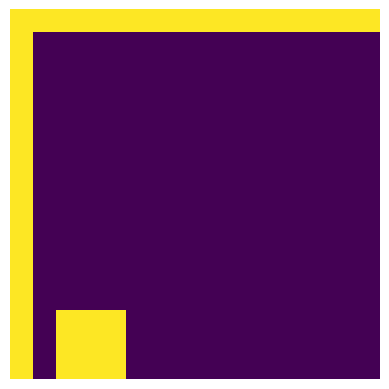

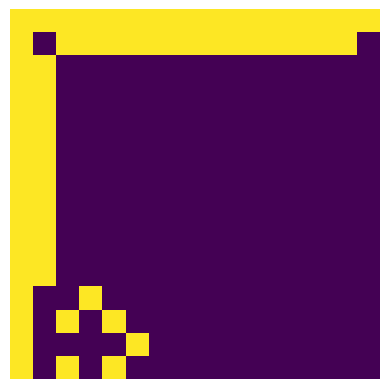

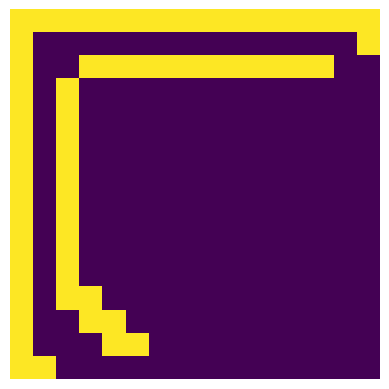

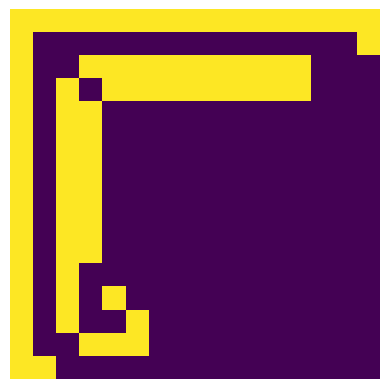

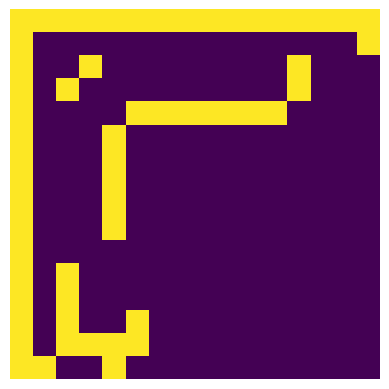

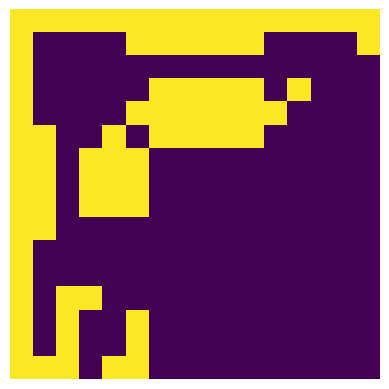

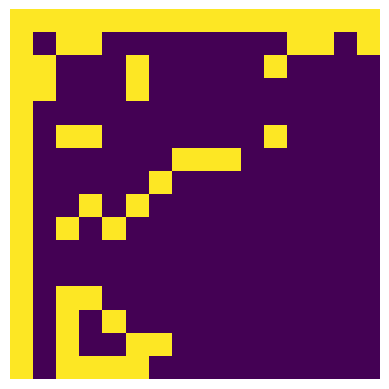

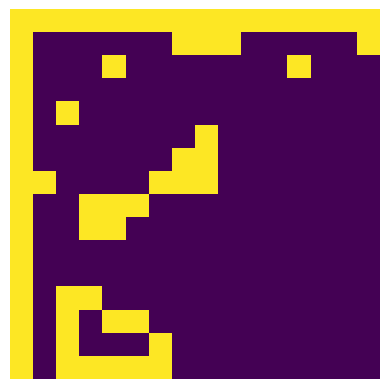

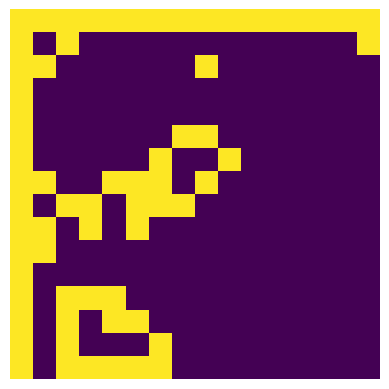

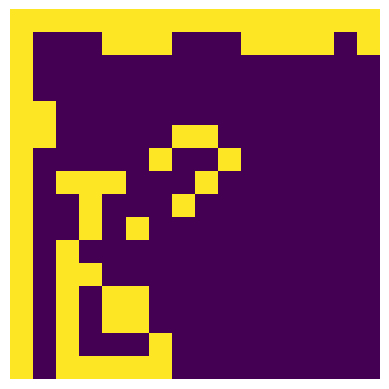

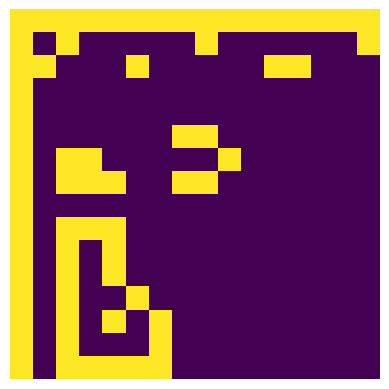

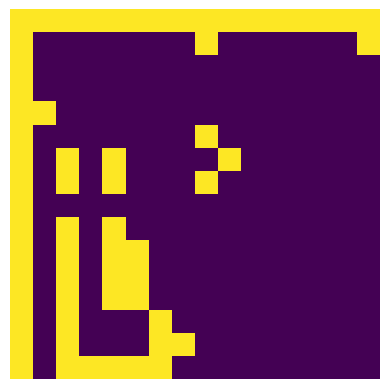

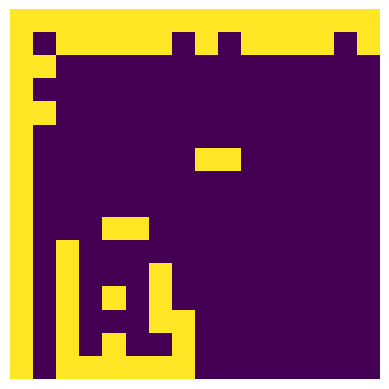

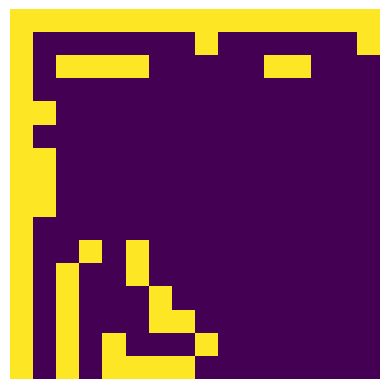

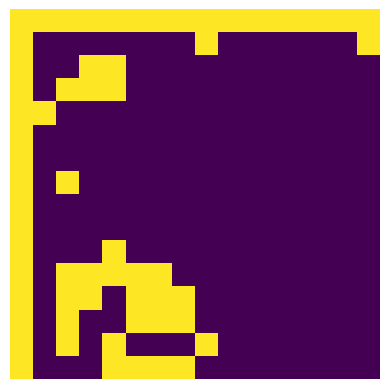

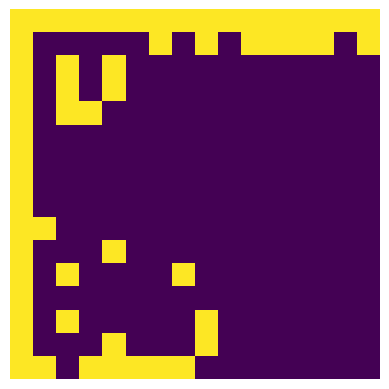

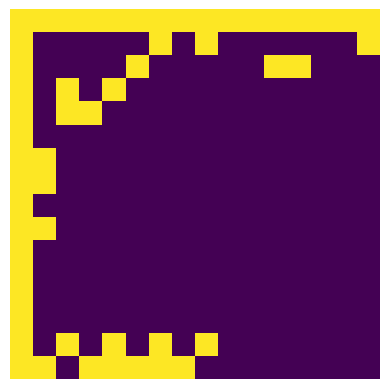

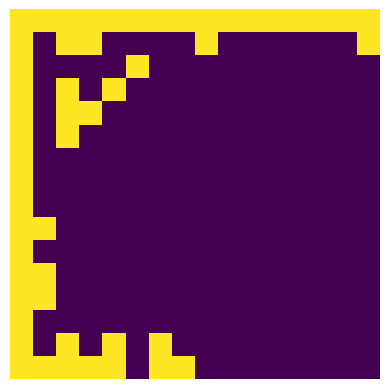

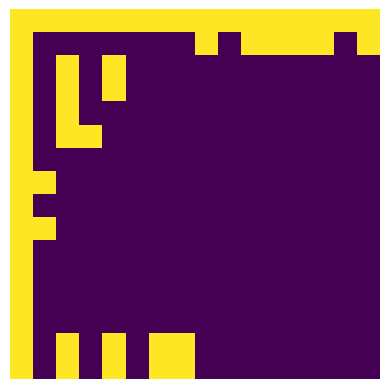

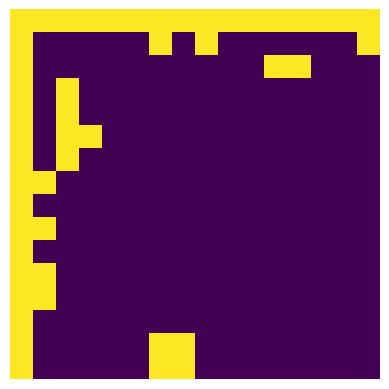

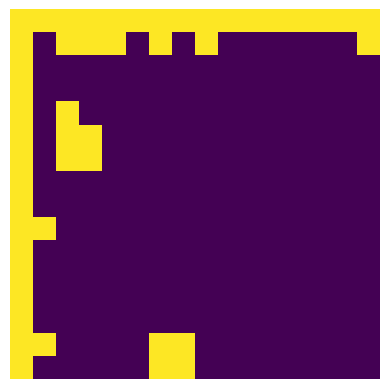

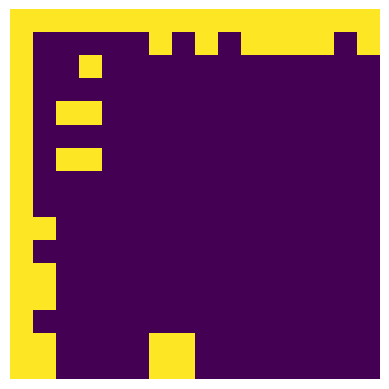

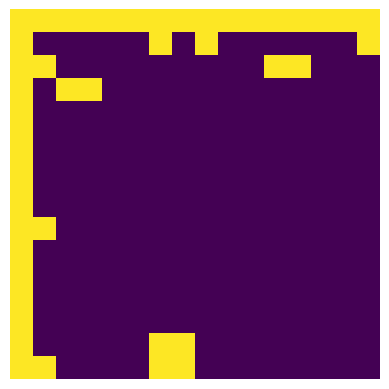

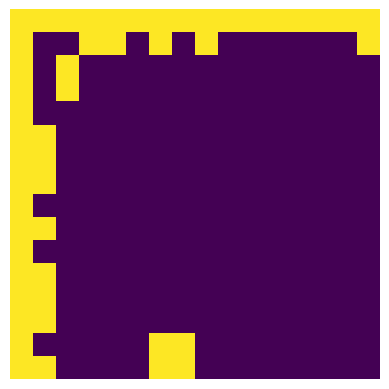

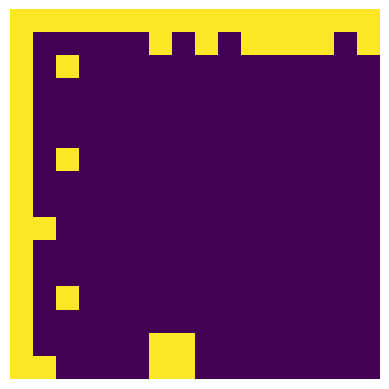

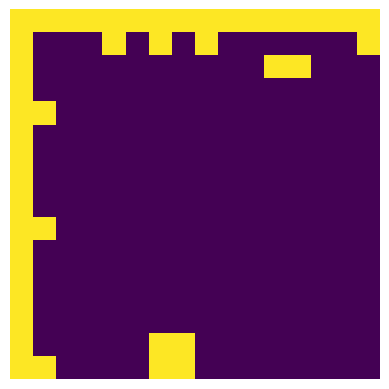

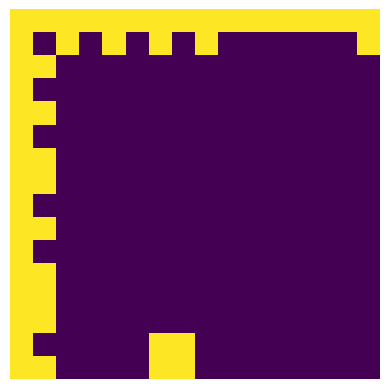

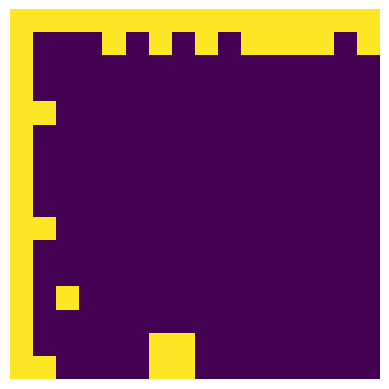

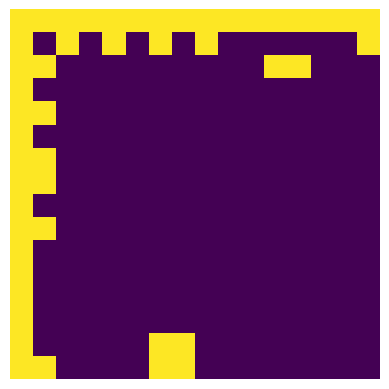

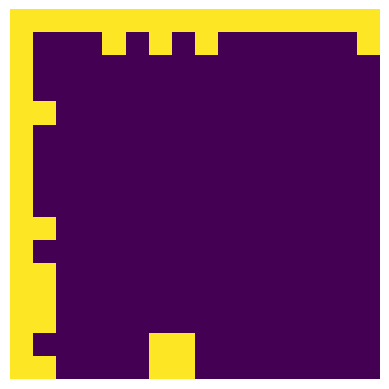

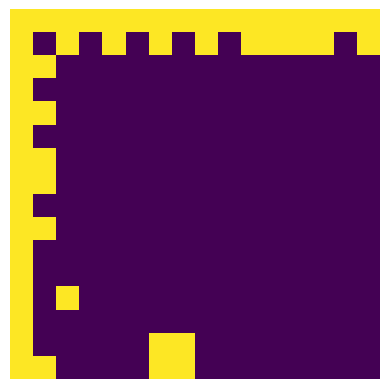

In [14]:
bv, border = bv_rn()
trace = generate_trace(declare, trans, bv)

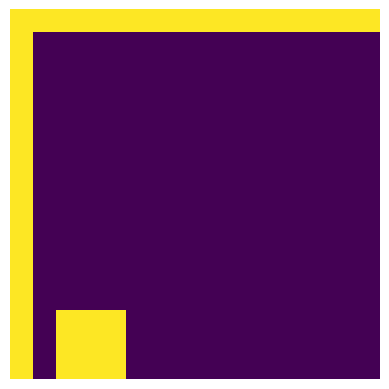

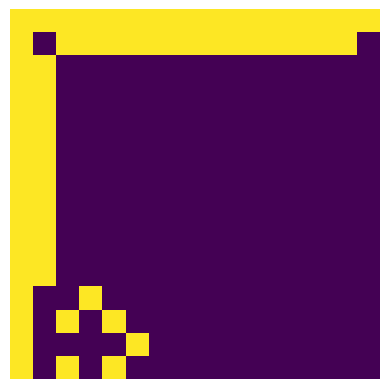

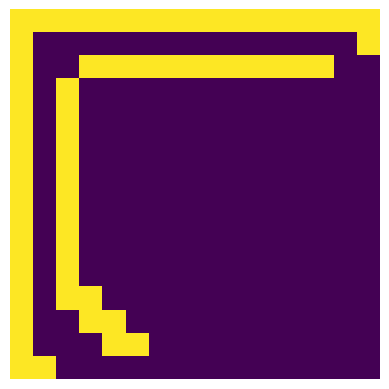

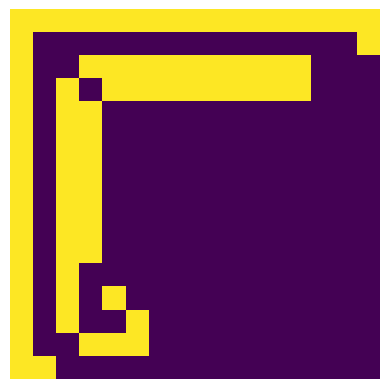

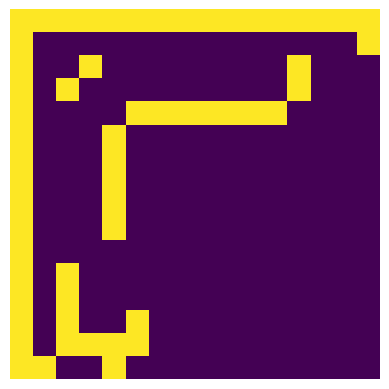

In [15]:
trace = generate_trace_k(declare, trans, bv, 5)

### Propriedades

Para verificar as propriedades enunciadas, pode-se também utilizar o Solver. Depois de se gerar um traço, basta acrescentar as asserções necessárias e invocar uma resolução.

 1. Todos os estados contém alguma célula normal viva.

Pode-se modelar esta condição com o seguinte predicado, já que o BitVector $border$ representa todas as células normais mortas:

$$ \forall_{x \in trace}, \quad x \neq border $$

 2. Toda a célula normal está viva em algum estado acessível.
 
Seja $o$ o resultado da disjunção lógica de todos os estados do traço. Se $o$ for igual ao estado com todas as células normais vivas, então todas as células normais estiveram vivas em pelo menos um estado, isto é:
 
$$ o == \neg full\_border | border $$

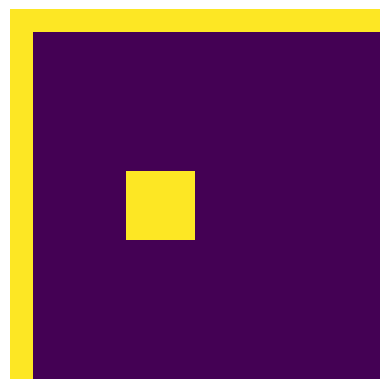

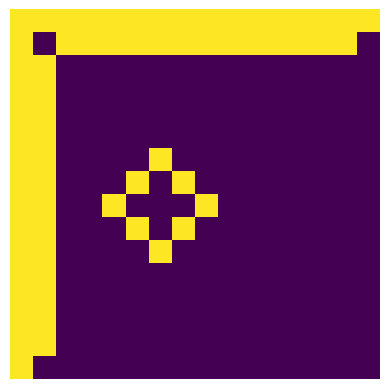

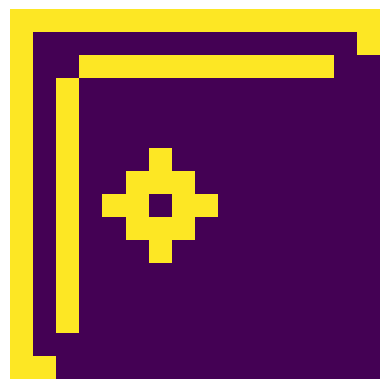

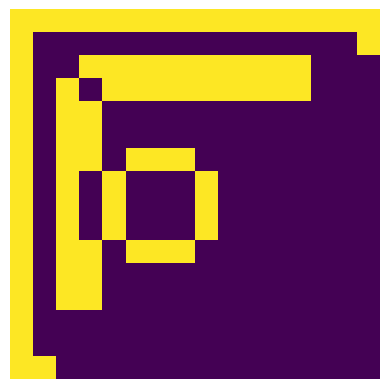

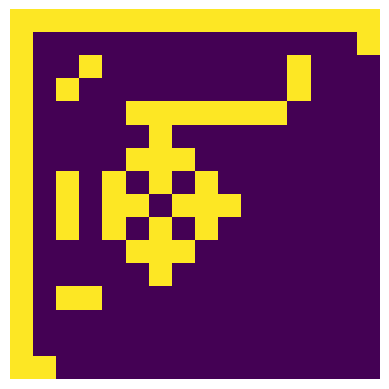

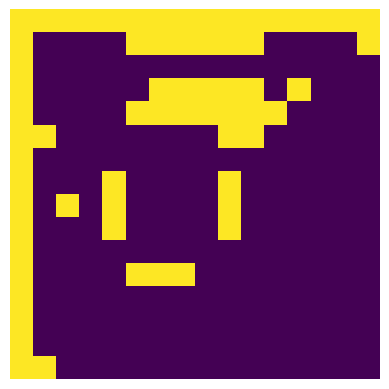

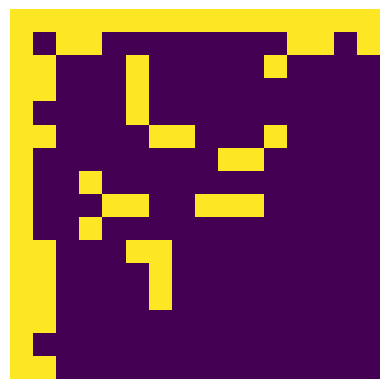

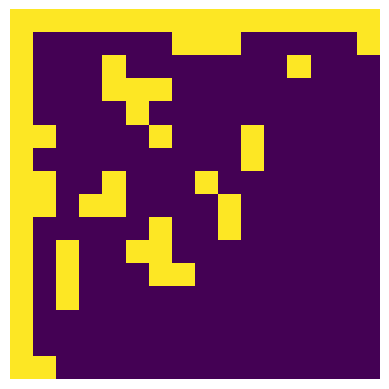

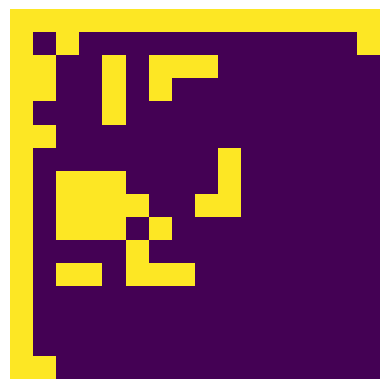

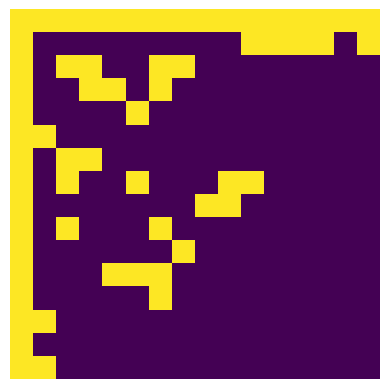

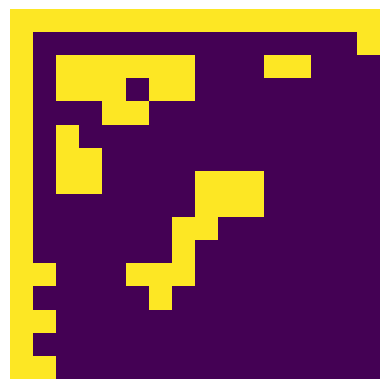

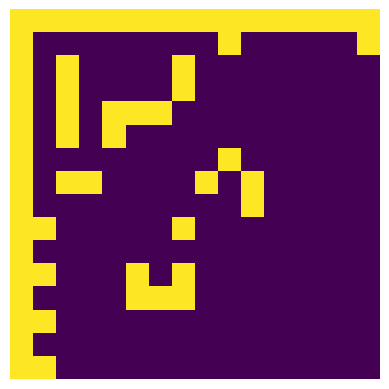

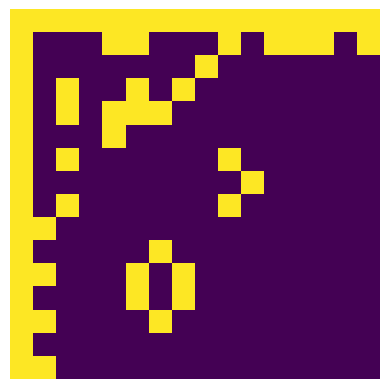

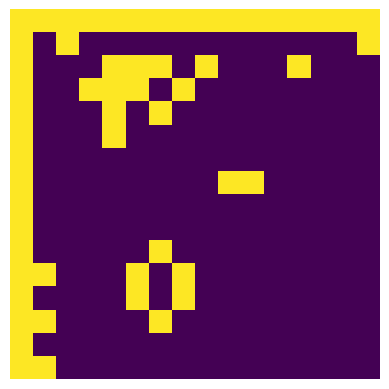

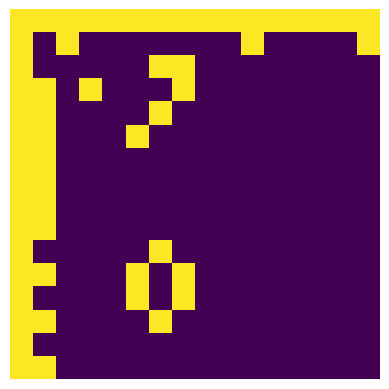

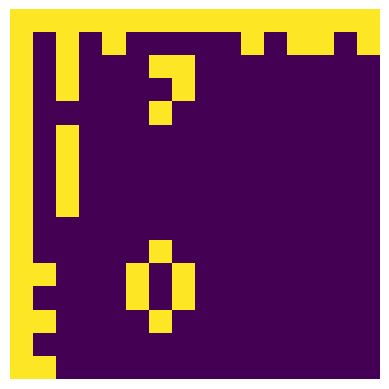

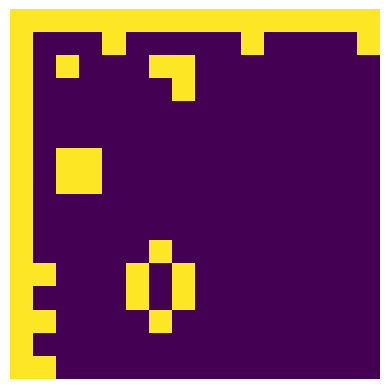

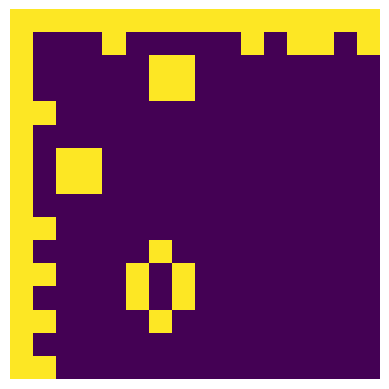

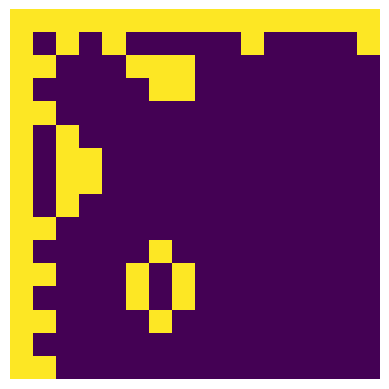

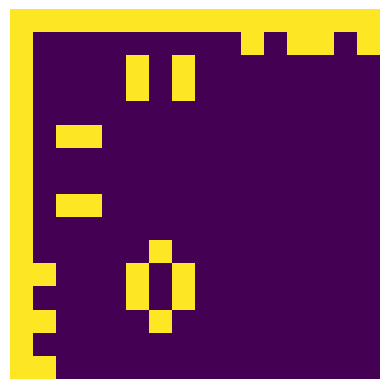

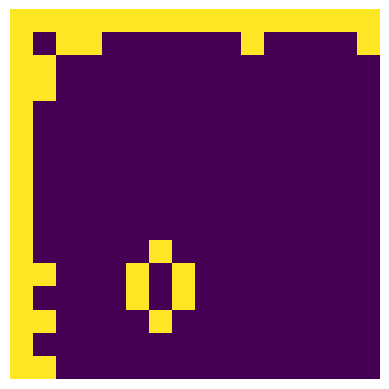

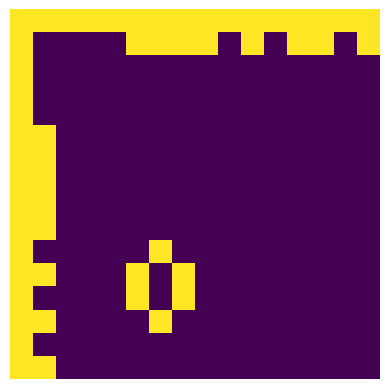

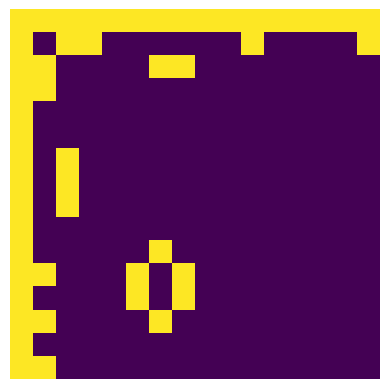

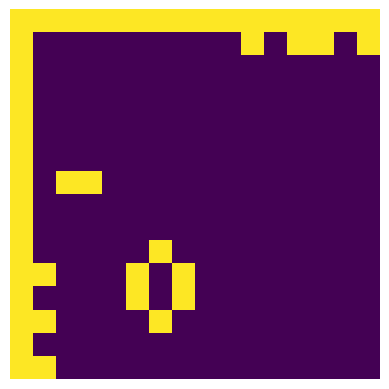

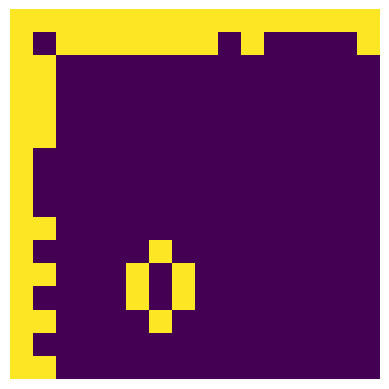

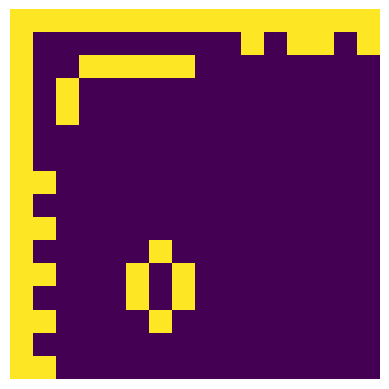

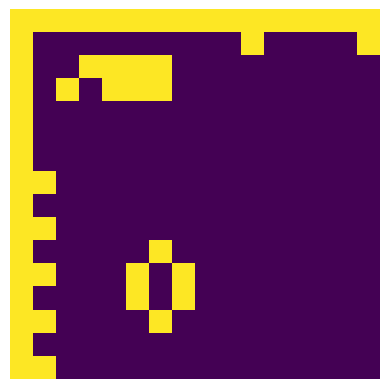

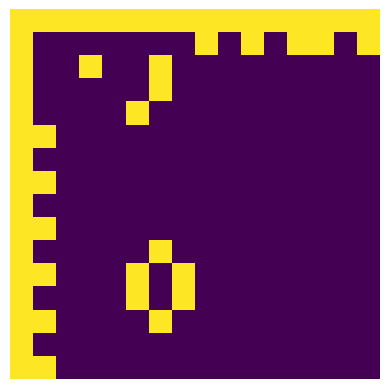

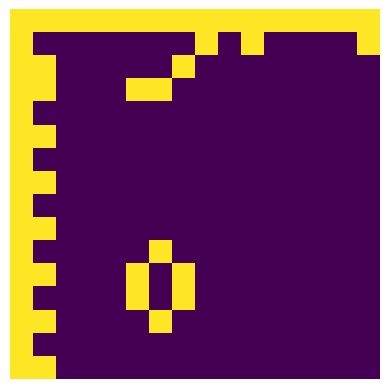

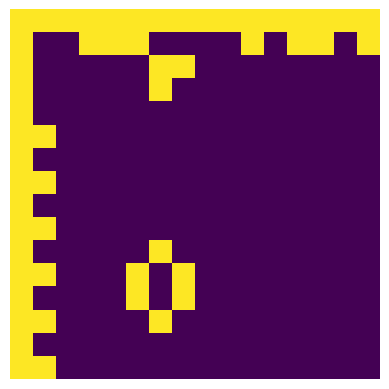

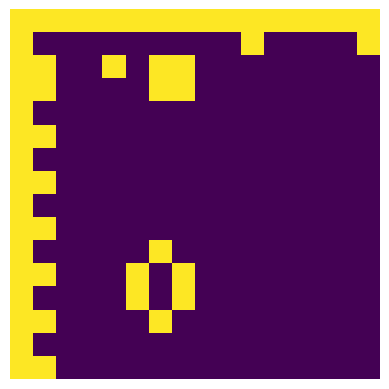

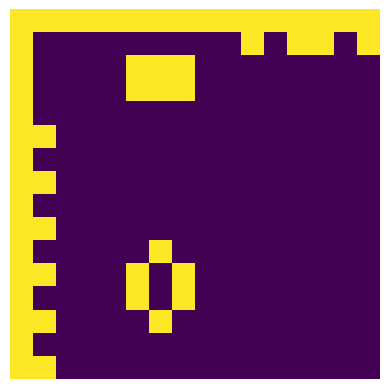

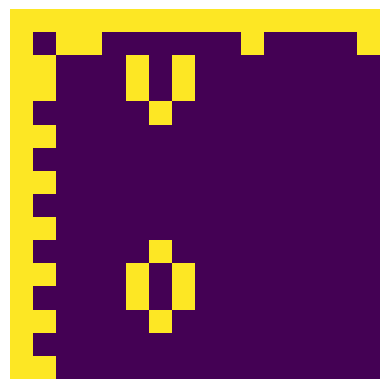

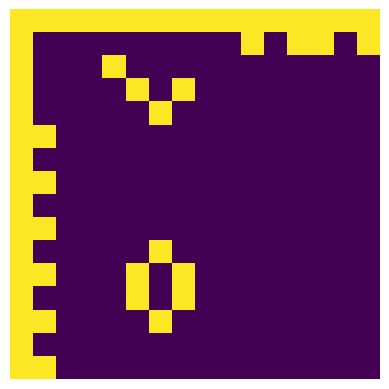

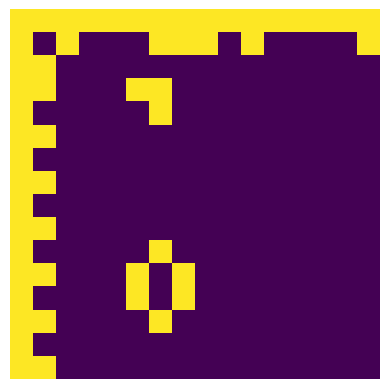

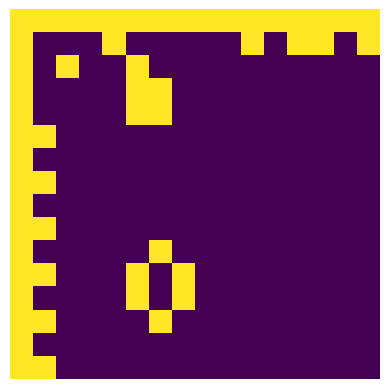

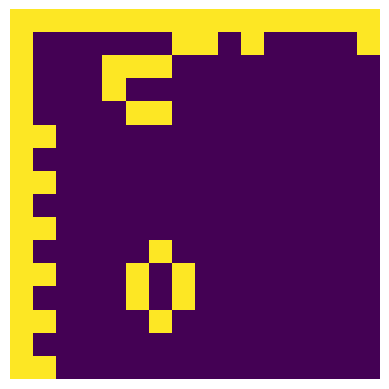

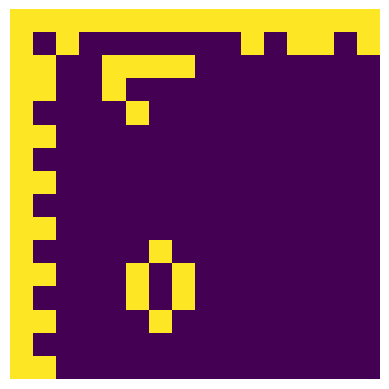

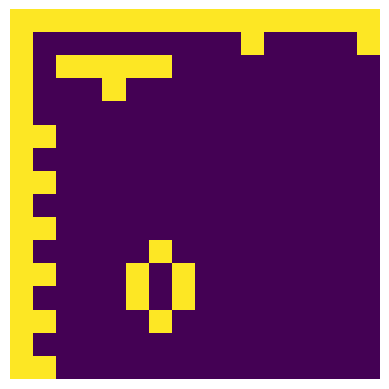

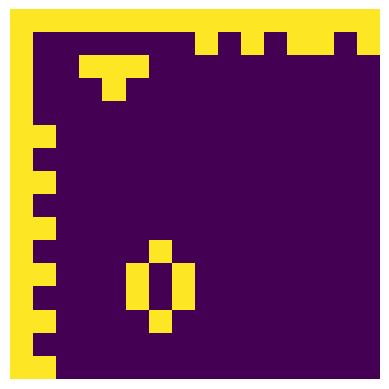

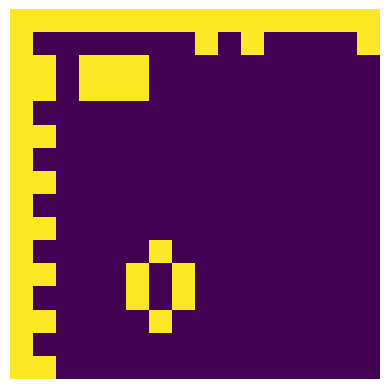

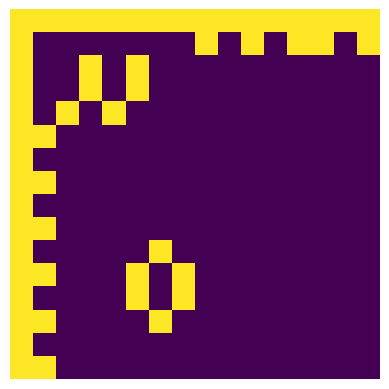

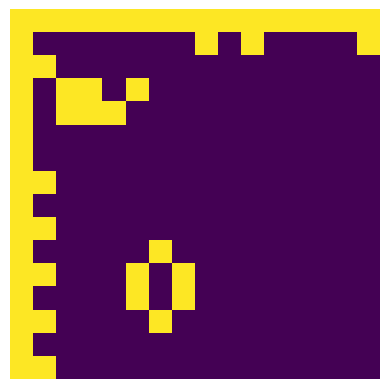

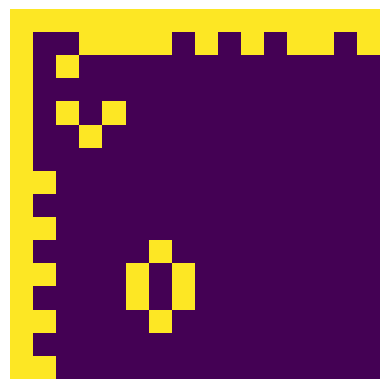

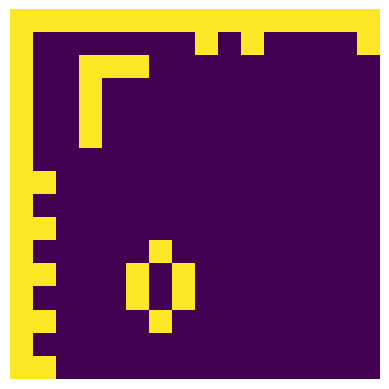

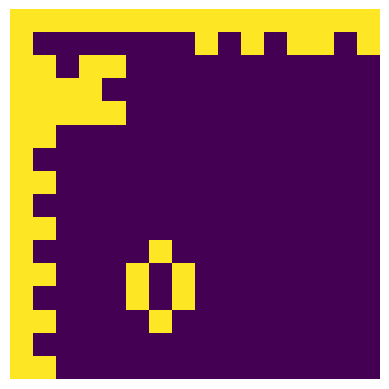

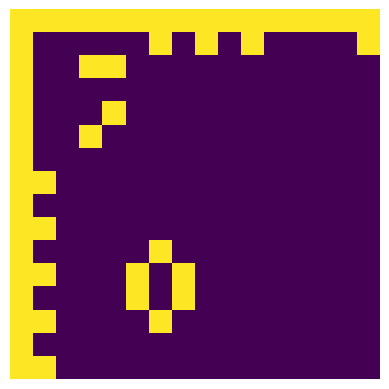

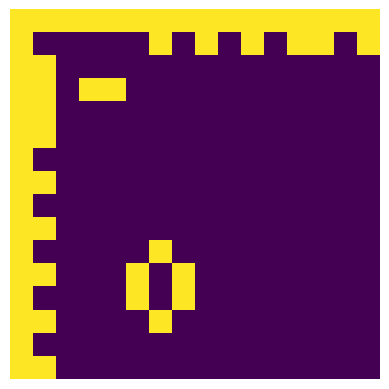

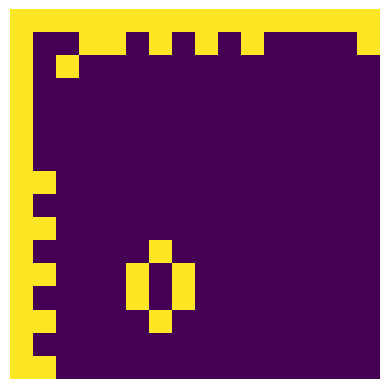

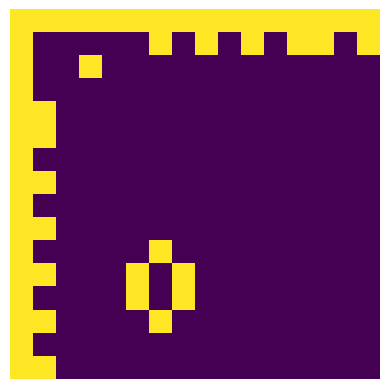

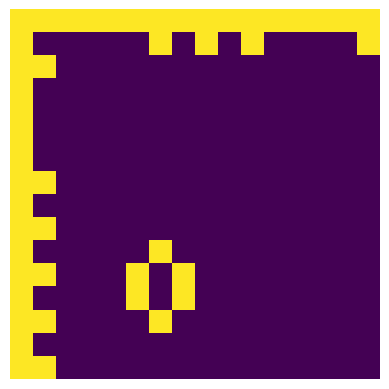

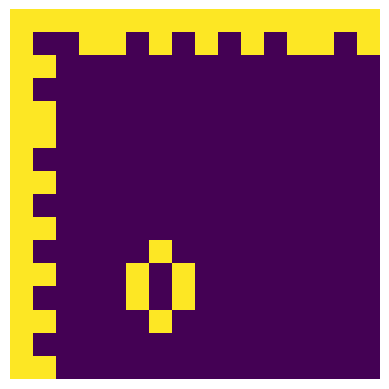

Todos os estados têm pelo menos uma célula viva.
Existem células que não ficaram vivas.


In [19]:
with Solver(name=name) as solver:
    initial, border = bv_rn()
    trace = generate_trace(declare, trans, initial)
    
    solver.push()    
    #state é uma constante de BitVector
    for state in trace:
        solver.add_assertion(Not(Equals(state, border)))
    if solver.solve():
        print("Todos os estados têm pelo menos uma célula viva.")
    else:
        print("Existe um estado sem células vivas.")
    solver.pop()
    #fazer o OR lógico de todos os bitvectors e ver se é igual ou diferente de BVZero(n*n)
    solver.push()
    solver.add_assertion(Equals(reduce(BVOr, trace), BVOr(BVNot(full_border), border)))
    if solver.solve():
        print("Todas as células estiveram vivas pelo menos uma vez.")
    else:
        print("Existem células que não ficaram vivas.")
    solver.pop()

In [ ]:
def fsm_always(declare, trans, inv):
    visited = set()
    #state é uma constante de BitVector
    initial, border = bv_rn()
    visited.add(initial)
    trace = generate_trace(declare, trans, initial,False)
    solver.push()
    solver.add_assertion(inv(trace))
    while not solver.solve():
        print("Todos os estados têm pelo menos uma célula viva.")    
        solver.pop()
        initial, border = bv_rn()
        #possivelmente contar quantas vezes se fez para se exaustar, ou até manter cuidado com o tamanho de visited
        while initial in visited:
            initial, border = bv_rn()
        visited.add(initial)
        trace = generate_trace(initial,p=False)
        solver.push()
        solver.add_assertion(inv(trace))
    print("Existe um estado que não tem uma célula viva.")
    for k,v in sorted(trace.items(), key = lambda x: x[1]):
        print_state(k)
    solver.pop()
    
    
def fsm_always_k(declare,trans,inv,K):
    return None
    
def inv_all_state(trace):
    return Or([Equals(state, border) for state in trace])

def inv_all_cell(trace):
    return Equals(reduce(BVOr, list(trace)), BVOr(BVNot(full_border), border))

fsm_always(declare, trans, inv_all_state)
fsm_always(declare, trans, inv_all_cell)

In [ ]:
with Solver(name=name) as solver:
    #fazer o OR lógico de todos os bitvectors e ver se é igual ou diferente de BVZero(n*n)
    #Valor expectável de possibilidades para configurações, de acordo com n e p
    max_med = ((n-2)**2)*comb((2*n-1),(2*n-1)*p)
    print(f'Valor Expectado de combinações: %d' % max_med)
    visited = set()
    #state é uma constante de BitVector
    initial, border = bv_rn()
    visited.add(initial)
    trace = generate_trace(declare, trans, initial,False)
    solver.push()
    solver.add_assertion((Equals(reduce(BVOr, list(trace)), BVOr(BVNot(full_border), border))))
    while not solver.solve():
        if len(visited) > max_med:
            print("Limite máximo excedido")
            break
        print("Existe uma célula que não esteve viva.")
        solver.pop()
        initial, border = bv_rn()
        #possivelmente contar quantas vezes se fez para se exaustar, ou até manter cuidado com o tamanho de visited
        while initial in visited:
            initial, border = bv_rn()
        visited.add(initial)
        trace = generate_trace(initial,p=False)
        solver.push()
        solver.add_assertion((Equals(reduce(BVOr, list(trace)), BVOr(BVNot(full_border), border))))
    else:
        print("Todas as células estiveram vivas pelo menos uma vez.")
        for k,v in sorted(trace.items(), key = lambda x: x[1]):
            print_state(k)
    solver.pop()